In [1]:
from astropy.io.votable import parse
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, f1_score, accuracy_score, precision_score, recall_score
import seaborn as sns

数据加载和初步可视化

In [2]:
# load gaia catalog data and check its ICRS coordinates range
gaia_csv_path = r'D:\github\Work\STUDY\work.7\SH9802CL98051001gaia_catalog.csv'
gaia_df = pd.read_csv(gaia_csv_path)
print("Gaia 星表列名:", gaia_df.columns)

ra_column = 'ra' 
dec_column = 'dec'  

ra_min = gaia_df[ra_column].min()
ra_max = gaia_df[ra_column].max()
dec_min = gaia_df[dec_column].min()
dec_max = gaia_df[dec_column].max()

print(f"赤经范围: {ra_min:.6f} 到 {ra_max:.6f} 度")
print(f"赤纬范围: {dec_min:.6f} 到 {dec_max:.6f} 度")

Gaia 星表列名: Index(['solution_id', 'DESIGNATION', 'SOURCE_ID', 'random_index', 'ref_epoch',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       ...
       'azero_gspphot', 'azero_gspphot_lower', 'azero_gspphot_upper',
       'ag_gspphot', 'ag_gspphot_lower', 'ag_gspphot_upper',
       'ebpminrp_gspphot', 'ebpminrp_gspphot_lower', 'ebpminrp_gspphot_upper',
       'libname_gspphot'],
      dtype='object', length=152)
赤经范围: 15.922007 到 17.597909 度
赤纬范围: 61.739010 到 63.284997 度


In [4]:
# load img data and SEx detected data
fits_path = r'D:\AI\images\SH9802CL98051001.fits'
sextractor_cat_path = r'D:\AI\test.cat'
output_csv_path = 'SH9802CL98051001_matched_catalog.csv'

with fits.open(fits_path) as hdul:
    header = hdul[0].header
    wcs = WCS(header)
    data = hdul[0].data

gaia_df['ra'] = pd.to_numeric(gaia_df['ra'], errors='coerce')
gaia_df['dec'] = pd.to_numeric(gaia_df['dec'], errors='coerce')

sextractor_df = pd.read_csv(sextractor_cat_path, sep='\s+', comment='#', header=None)

num_columns = len(sextractor_df.columns)
if num_columns == 3:
    sextractor_df.columns = ['FLUX', 'X_IMAGE', 'Y_IMAGE']
else:
    raise ValueError(f"未知的列数: {num_columns}")

print("SExtractor 探测到的源:")
print(sextractor_df.head())

SExtractor 探测到的源:
        FLUX     X_IMAGE  Y_IMAGE
0   2750.145  16881.8008   2.6050
1  12017.330   9850.3408   2.0775
2   3395.846   5599.5967   3.1919
3   3621.705   8605.5000   2.9888
4   3800.678  16523.0117   3.0180


In [5]:
# change SEx XY coords to sky coords
sextractor_coords = wcs.all_pix2world(sextractor_df[['X_IMAGE', 'Y_IMAGE']], 0)
sextractor_df['RA'] = sextractor_coords[:, 0]
sextractor_df['DEC'] = sextractor_coords[:, 1]
print("SExtractor 探测到的源的天球坐标:")
print(sextractor_df[['RA', 'DEC']].head())

SExtractor 探测到的源的天球坐标:
          RA        DEC
0  17.941474  61.729993
1  16.707625  61.739370
2  15.961482  61.739761
3  16.489118  61.739954
4  17.878544  61.730778


In [6]:
# match
gaia_coords = SkyCoord(ra=gaia_df['ra'].values * u.degree, dec=gaia_df['dec'].values * u.degree)
sextractor_coords = SkyCoord(ra=sextractor_df['RA'].values * u.degree, dec=sextractor_df['DEC'].values * u.degree)

max_separation = 8 * u.arcsec  # max sky coord distance set（5~10左右合适）

idx, d2d, _ = sextractor_coords.match_to_catalog_sky(gaia_coords)

sex_matched_mask = d2d < max_separation
sextractor_df['MATCHED'] = sex_matched_mask.astype(int)
sextractor_df['SEPARATION'] = d2d.arcsec


所有源（包括匹配成功和失败的）已保存到 SH9802CL98051001_matched_catalog.csv


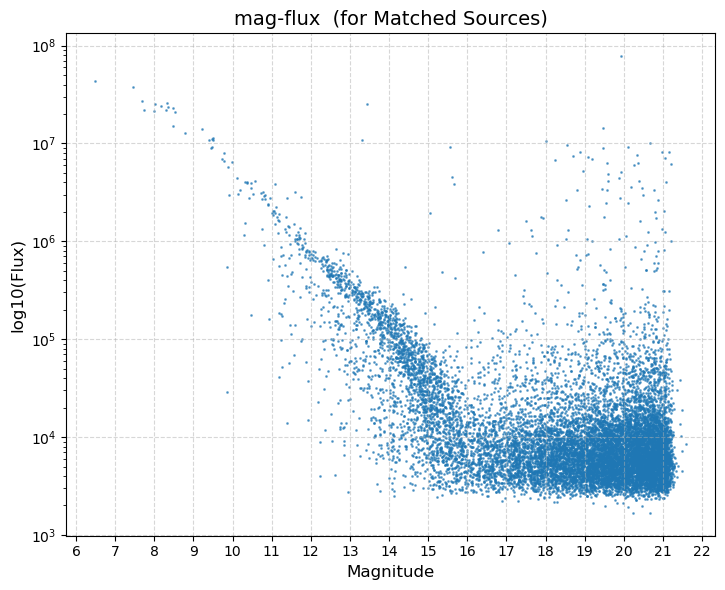

In [7]:
# add gaia mag to SEx catalog for successfully matched objects
if 'phot_g_mean_mag' in gaia_df.columns:
    sextractor_df['GAIA_MAG'] = np.nan
    sextractor_df.loc[sex_matched_mask, 'GAIA_MAG'] = gaia_df.iloc[idx[sex_matched_mask]]['phot_g_mean_mag'].values

sextractor_df.to_csv(output_csv_path, index=False)
print(f"\n所有源（包括匹配成功和失败的）已保存到 {output_csv_path}")

matched_sources = sextractor_df[sex_matched_mask]

# plot mag-flux fig for matched objects
if len(matched_sources) == 0:
    raise ValueError("匹配成功的源为空，无法绘制散点图。")

flux = matched_sources['FLUX'].values
gaia_mag = matched_sources['GAIA_MAG'].values

valid_mask = (~np.isnan(flux)) & (~np.isinf(flux)) & (flux > 0) & (~np.isnan(gaia_mag)) & (~np.isinf(gaia_mag))
flux = flux[valid_mask]
gaia_mag = gaia_mag[valid_mask]
# comment:: 不如保存匹配星表的时候就用这种有效样本来保存？

if len(valid_mask) == 0:
    raise ValueError("有效数据为空，无法绘制散点图。")
plt.figure(figsize=(14, 6))

# 星等与log10流量的关系
plt.subplot(122)
plt.scatter(gaia_mag, flux, alpha=0.6, s=1)  
plt.xlabel('Magnitude', fontsize=12)
plt.xticks(np.arange(6,23))
plt.ylabel('log10(Flux)', fontsize=12)
plt.yscale('log')  # comment:: 用yscale更好，有一个小刻度可以辅助更好的对比指数数量
plt.title('mag-flux  (for Matched Sources)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('./firstmatch_mag-flux.png')  # comment:: 如有必要，可以将图片保存下来，放在如media之类的文件夹中

以下是一个简单的测试参数的示例，用于测试不同的匹配最大距离对匹配数量和有效匹配星等-流量分布图的影响：

有效匹配数（ms=3.00 arcsec）: 4792
有效匹配数（ms=4.09 arcsec）: 6590
有效匹配数（ms=5.18 arcsec）: 8542
有效匹配数（ms=6.27 arcsec）: 10642
有效匹配数（ms=7.36 arcsec）: 12592
有效匹配数（ms=8.45 arcsec）: 14297
有效匹配数（ms=9.55 arcsec）: 15812
有效匹配数（ms=10.64 arcsec）: 16968
有效匹配数（ms=11.73 arcsec）: 17934
有效匹配数（ms=12.82 arcsec）: 18583
有效匹配数（ms=13.91 arcsec）: 19074
有效匹配数（ms=15.00 arcsec）: 19395


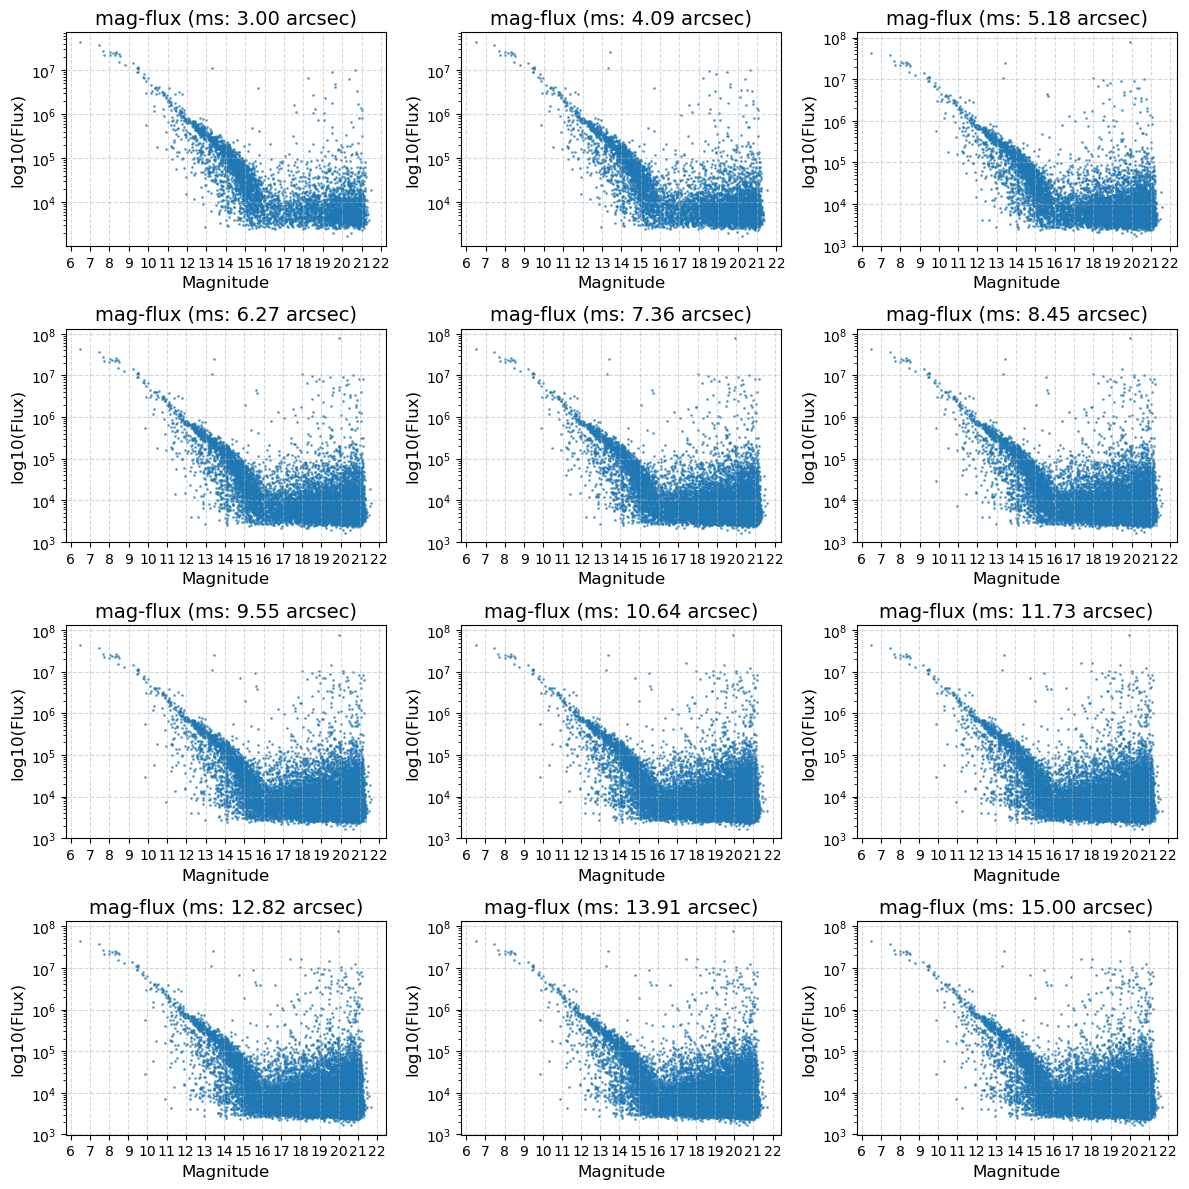

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from math import ceil

def test_max_separation(max_separation_list):
    num_plots = len(max_separation_list)
    fig_width = 3
    fig_height = ceil(num_plots / fig_width)
    
    if fig_height == 1 and fig_width == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
    else:
        fig, axes = plt.subplots(nrows=fig_height, ncols=fig_width, figsize=(fig_width*4, fig_height*3))
    
    axes = axes.flatten()
    
    for id, max_sep in enumerate(max_separation_list):
        max_separation = max_sep.to(u.degree)
        
        gaia_coords = SkyCoord(ra=gaia_df['ra'].values * u.degree, dec=gaia_df['dec'].values * u.degree)
        sextractor_coords = SkyCoord(ra=sextractor_df['RA'].values * u.degree, dec=sextractor_df['DEC'].values * u.degree)
        idx, d2d, _ = sextractor_coords.match_to_catalog_sky(gaia_coords)
        
        sex_matched_mask = d2d < max_separation
        flux = sextractor_df['FLUX'].values[sex_matched_mask]
        gaia_mag = gaia_df.iloc[idx, :]['phot_g_mean_mag'].values[sex_matched_mask]
        
        valid_mask = (
            ~np.isnan(flux) & ~np.isinf(flux) & (flux > 0) &
            ~np.isnan(gaia_mag) & ~np.isinf(gaia_mag)
        )
        flux = flux[valid_mask]
        gaia_mag = gaia_mag[valid_mask]
        
        if valid_mask.sum() == 0:
            raise ValueError("有效数据为空，无法绘制散点图。")
        else:
            print(f"有效匹配数（ms={max_sep.value:.2f} arcsec）: {valid_mask.sum()}")
        
        ax = axes[id]
        ax.scatter(gaia_mag, flux, alpha=0.6, s=1)
        ax.set_xlabel('Magnitude', fontsize=12)
        ax.set_xticks(np.arange(6, 23))
        ax.set_ylabel('log10(Flux)', fontsize=12)
        ax.set_yscale('log')
        ax.set_title(f'mag-flux (ms: {max_sep.value:.2f} arcsec)', fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.5)
    
    fig.tight_layout()  
    return fig, axes

max_separation_list = np.linspace(3, 15, 12) * u.arcsec
fig, axes = test_max_separation(max_separation_list)
plt.show()

In [ ]:
output_csv_path = 'SH9802CL98051001_matched_catalog.csv'
sextractor_df = pd.read_csv(output_csv_path)

required_columns = ['MATCHED', 'FLUX', 'GAIA_MAG']
if not all(col in sextractor_df.columns for col in required_columns):
    missing = [col for col in required_columns if col not in sextractor_df.columns]
    print(f"错误：数据文件缺少必要列 {missing}")
    sys.exit(1)

matched_sources = sextractor_df[sextractor_df['MATCHED'] == 1]
if len(matched_sources) == 0:
    print("错误：没有MATCHED=1的匹配源")
    sys.exit(1)

flux = matched_sources['FLUX'].values
mag = matched_sources['GAIA_MAG'].values

valid_mask = (~np.isnan(flux)) & (~np.isinf(flux)) & (flux > 0) & (~np.isnan(mag))
flux = flux[valid_mask]
mag = mag[valid_mask]

if len(mag) == 0:
    print("错误：所有匹配源的FLUX/GAIA_MAG数据无效")
    print("可能原因：")
    print("- 流量值全是NaN/零/负数")
    print("- 星等值全是NaN")
    sys.exit(1)

print(f"成功加载 {len(mag)} 个有效匹配源")
print(f"星等范围: {np.min(mag):.2f} 到 {np.max(mag):.2f}")
print(f"流量范围: {np.min(flux):.2e} 到 {np.max(flux):.2e}")

成功加载 13609 个有效匹配源
星等范围: 6.49 到 21.58
流量范围: 1.68e+03 到 7.80e+07


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d

output_csv_path = 'SH9802CL98051001_matched_catalog.csv'
sextractor_df = pd.read_csv(output_csv_path)

matched_sources = sextractor_df[sextractor_df['MATCHED'] == 1]
flux = matched_sources['FLUX'].values
mag = matched_sources['GAIA_MAG'].values

valid = (~np.isnan(flux)) & (~np.isinf(flux)) & (flux > 0) & (~np.isnan(mag))
flux = flux[valid]
mag = mag[valid]

lower_mag = 8
upper_mag = 16
selected = (mag >= lower_mag) & (mag <= upper_mag)
mag_range = mag[selected]
log_flux_range = np.log10(flux[selected])

print(f"选定星等范围: {lower_mag:.1f} 到 {upper_mag:.1f} mag，共 {len(mag_range)} 个点")

选定星等范围: 8.0 到 16.0 mag，共 2498 个点


In [ ]:
sort_idx = np.argsort(mag_range)
mag_sorted = mag_range[sort_idx]
log_flux_sorted = log_flux_range[sort_idx]

window_points = max(int(len(mag_sorted) / 20), 5)
smoothed = uniform_filter1d(log_flux_sorted, size=window_points)

residuals = log_flux_sorted - smoothed
std = np.std(residuals)
n_sigma = 1

keep_idx = np.abs(residuals) < n_sigma * std
mag_clean = mag_sorted[keep_idx]
log_flux_clean = log_flux_sorted[keep_idx]

print(f"清洗后保留 {len(mag_clean)}/{len(mag_range)} 个点（{len(mag_clean)/len(mag_range):.1%}）")


清洗后保留 1854/2498 个点（74.2%）


In [ ]:
def linear_func(x, a, b):
    """线性函数：y = a*x + b"""
    return a * x + b

def quadratic_func(x, a, b, c):
    """二次函数：y = a*x² + b*x + c"""
    return a * x**2 + b * x + c

In [ ]:
def total_residual_error(split_val):
    mask1 = mag_clean <= split_val
    mask2 = mag_clean > split_val
    if sum(mask1) < 3 or sum(mask2) < 5:
        return np.inf
    try:
        p1, _ = curve_fit(linear_func, mag_clean[mask1], log_flux_clean[mask1])
        p2, _ = curve_fit(quadratic_func, mag_clean[mask2], log_flux_clean[mask2])
        err1 = np.sum((log_flux_clean[mask1] - linear_func(mag_clean[mask1], *p1))**2)
        err2 = np.sum((log_flux_clean[mask2] - quadratic_func(mag_clean[mask2], *p2))**2)
        return err1 + err2
    except:
        return np.inf

search_range = np.linspace(lower_mag + 0.5, upper_mag - 1.5, 50)
split_point = min(search_range, key=total_residual_error)
print(f"最优分段点: {split_point:.2f} mag")


最优分段点: 14.26 mag


拟合结果:
亮星段: log10(flux) = -0.4246 * mag + 10.8722
暗星段: log10(flux) = 0.1458 * mag² + -4.9921 * mag + 46.4381


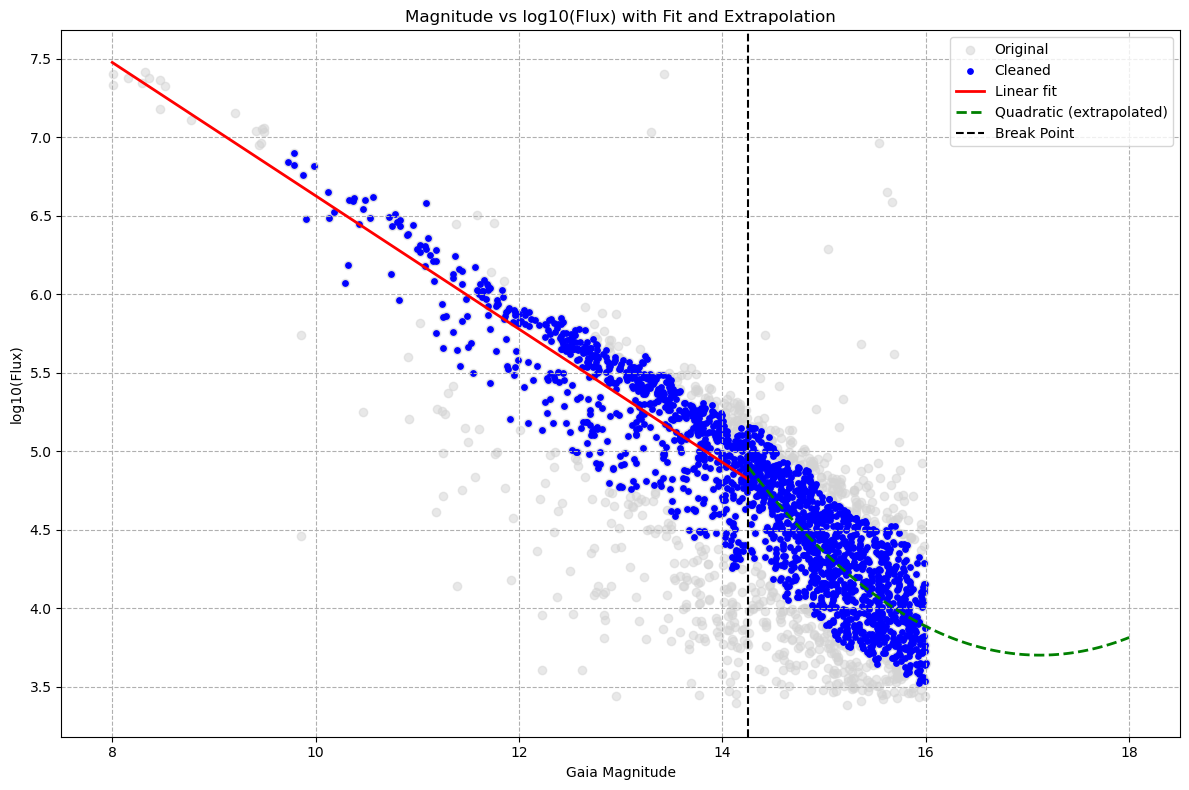

In [14]:
mask1 = mag_clean <= split_point
mask2 = mag_clean > split_point

popt1, _ = curve_fit(linear_func, mag_clean[mask1], log_flux_clean[mask1])
popt2, _ = curve_fit(quadratic_func, mag_clean[mask2], log_flux_clean[mask2])

print("拟合结果:")
print(f"亮星段: log10(flux) = {popt1[0]:.4f} * mag + {popt1[1]:.4f}")
print(f"暗星段: log10(flux) = {popt2[0]:.4f} * mag² + {popt2[1]:.4f} * mag + {popt2[2]:.4f}")

plt.figure(figsize=(12, 8))
plt.scatter(mag_range, log_flux_range, c='lightgray', alpha=0.5, label='Original')
plt.scatter(mag_clean, log_flux_clean, c='blue', s=15, label='Cleaned')

x_fit1 = np.linspace(lower_mag, split_point, 100)
x_fit2 = np.linspace(split_point, upper_mag + 2, 100)
plt.plot(x_fit1, linear_func(x_fit1, *popt1), 'r-', lw=2, label='Linear fit')
plt.plot(x_fit2, quadratic_func(x_fit2, *popt2), 'g--', lw=2, label='Quadratic (extrapolated)')

plt.axvline(split_point, color='k', linestyle='--', label='Break Point')
plt.xlabel('Gaia Magnitude')
plt.ylabel('log10(Flux)')
plt.title('Magnitude vs log10(Flux) with Fit and Extrapolation')
plt.legend()
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()


In [15]:
sextractor_df['CALCULATED_MAG'] = np.nan

def estimate_mag_from_flux(log_flux_val):
    if log_flux_val <= linear_func(split_point, *popt1):
        return (log_flux_val - popt1[1]) / popt1[0]
    else:
        a, b, c = popt2
        delta = b**2 - 4 * a * (c - log_flux_val)
        if delta < 0: return np.nan
        roots = [(-b + np.sqrt(delta)) / (2 * a), (-b - np.sqrt(delta)) / (2 * a)]
        return max(roots) if all(r < split_point for r in roots) else min(roots)

for i, row in sextractor_df.iterrows():
    f = row['FLUX']
    if pd.notna(f) and f > 0:
        sextractor_df.at[i, 'CALCULATED_MAG'] = estimate_mag_from_flux(np.log10(f))

matching_threshold = 1.0
sextractor_df['FLUX_MAG_MATCHED'] = (np.abs(sextractor_df['CALCULATED_MAG'] - sextractor_df['GAIA_MAG']) <= matching_threshold).astype(int)
print(f"三维匹配完成：成功匹配 {sextractor_df['FLUX_MAG_MATCHED'].sum()} 个源")


三维匹配完成：成功匹配 2882 个源


In [ ]:
from scipy.spatial import cKDTree

fits_path = r"D:\AI\images\SH9802CL98051001.fits"  
with fits.open(fits_path) as hdul:
    wcs = WCS(hdul[0].header)

world_coords = np.vstack([gaia_df['ra'].values, gaia_df['dec'].values]).T
x_pix, y_pix = wcs.world_to_pixel_values(world_coords[:, 0], world_coords[:, 1])
gaia_df['X'] = x_pix
gaia_df['Y'] = y_pix
gaia_df['MAG'] = gaia_df['phot_g_mean_mag']

def weighted_3d_match_by_estimated_mag(sextractor_df, gaia_df, alpha=1.0, beta=1, threshold=5.0):
    sextractor_df = sextractor_df.copy()
    sextractor_df['XYM_MATCHED'] = 0 

    valid_s = sextractor_df[['X_IMAGE', 'Y_IMAGE', 'CALCULATED_MAG']].dropna()
    valid_g = gaia_df[['X', 'Y', 'MAG']].dropna()
    if valid_s.empty or valid_g.empty:
        print("三维匹配失败：无有效源")
        return sextractor_df

    sex_coords = np.vstack([
        alpha * valid_s['X_IMAGE'].values,
        alpha * valid_s['Y_IMAGE'].values,
        beta * valid_s['CALCULATED_MAG'].values
    ]).T

    gaia_coords = np.vstack([
        alpha * valid_g['X'].values,
        alpha * valid_g['Y'].values,
        beta * valid_g['MAG'].values
    ]).T

    tree = cKDTree(gaia_coords)
    distances, indices = tree.query(sex_coords, distance_upper_bound=threshold)

    matched_indices = valid_s.index.to_numpy()
    for i, (dist, idx) in enumerate(zip(distances, indices)):
        if idx != len(valid_g) and np.isfinite(dist):
            sextractor_df.at[matched_indices[i], 'XYM_MATCHED'] = 1  

    print(f"三维匹配完成：成功匹配 {sextractor_df['XYM_MATCHED'].sum()} 个源")
    return sextractor_df


In [21]:
sextractor_df.to_csv("matched_sextractor_sources.csv", index=False)

In [22]:
sextractor_df = weighted_3d_match_by_estimated_mag(sextractor_df, gaia_df)

三维匹配完成：成功匹配 1796 个源


In [ ]:
import pandas as pd

def remove_rows_without_gaia_mag(input_file, output_file):
    """
    读取CSV文件并删除GAIA_MAG列为空的行
    
    参数:
        input_file (str): 输入CSV文件路径
        output_file (str): 输出CSV文件路径
    """
    df = pd.read_csv(input_file)
    
    print(f"原始文件行数: {len(df)}")
    
    df_cleaned = df.dropna(subset=['GAIA_MAG'])
    
    print(f"清理后行数: {len(df_cleaned)}")
    print(f"删除了 {len(df) - len(df_cleaned)} 行")
    
    df_cleaned.to_csv(output_file, index=False)
    print(f"清理后的数据已保存到: {output_file}")

input_csv = "D:\github\Work\STUDY\matched_sextractor_sources.csv"  
output_csv = "output_cleaned.csv"  

remove_rows_without_gaia_mag(input_csv, output_csv)

原始文件行数: 57230
清理后行数: 13609
删除了 43621 行
清理后的数据已保存到: output_cleaned.csv


In [ ]:
plt.rcParams['font.family'] = 'SimHei'

fits_image = fits.open(r'D:\AI\images\SH9802CL98051001.fits')
data = fits_image[0].data

okok_df = pd.read_csv(r'D:\github\Work\STUDY\matched_sextractor_sources.csv')

okok_df_cleaned = okok_df.dropna(subset=['GAIA_MAG'])

print("\n=== 清洗后的数据 ===")
print(okok_df_cleaned.describe())

valid_samples = okok_df_cleaned[okok_df_cleaned['GAIA_MAG'] >= 0]

print(f"有效样本数: {valid_samples.shape[0]}")

if valid_samples.shape[0] == 0:
    print("没有有效的样本，请检查筛选条件。")
else:
    min_mag = valid_samples['GAIA_MAG'].min()
    max_mag = valid_samples['GAIA_MAG'].max()
    print(f"最小星等: {min_mag}, 最大星等: {max_mag}")


=== 清洗后的数据 ===
               FLUX       X_IMAGE       Y_IMAGE            RA           DEC  \
count  1.360900e+04  13609.000000  13609.000000  13609.000000  13609.000000   
mean   1.008630e+05   9820.938527   9528.413953     16.713030     62.530358   
std    1.190823e+06   2735.560602   5768.559690      0.491454      0.479752   
min    1.678838e+03   5372.472200      2.077500     15.918685     61.737501   
25%    4.885613e+03   7353.604000   3796.797600     16.269050     62.053515   
50%    7.758542e+03   9883.684600  10209.698200     16.724967     62.586693   
75%    1.636036e+04  12114.657200  14819.424800     17.125433     62.969622   
max    7.799604e+07  14928.373000  18583.414100     17.601414     63.280754   

       MATCHED    SEPARATION      GAIA_MAG  CALCULATED_MAG  FLUX_MAG_MATCHED  \
count  13609.0  13609.000000  13609.000000    13609.000000      13609.000000   
mean       1.0      4.167800     18.497290       16.135909          0.211772   
std        0.0      2.176379    

In [ ]:
import pandas as pd

def calculate_magnitude_stats(csv_file):
    """
    计算满足XYM_MATCHED为1的数据中GAIA_MAG和CALCULATED_MAG的最大值与最小值
    
    参数:
        csv_file (str): CSV文件路径
    """
    df = pd.read_csv(csv_file)
    
    matched_data = df[df['XYM_MATCHED'] == 1]
    
    gaia_min = matched_data['GAIA_MAG'].min()
    gaia_max = matched_data['GAIA_MAG'].max()
    
    calc_min = matched_data['CALCULATED_MAG'].min()
    calc_max = matched_data['CALCULATED_MAG'].max()
    
    print("满足XYM_MATCHED=1的星等统计:")
    print(f"GAIA_MAG - 最小值: {gaia_min:.3f}, 最大值: {gaia_max:.3f}")
    print(f"CALCULATED_MAG - 最小值: {calc_min:.3f}, 最大值: {calc_max:.3f}")

input_file = "D:\github\Work\STUDY\output_cleaned.csv"  # 替换为你的CSV文件路径
calculate_magnitude_stats(input_file)

满足XYM_MATCHED=1的星等统计:
GAIA_MAG - 最小值: 9.464, 最大值: 21.361
CALCULATED_MAG - 最小值: 12.339, 最大值: 17.842


In [ ]:
import pandas as pd

df = pd.read_csv('D:\github\Work\STUDY\output_cleaned.csv') 

df['ANY_MATCHED'] = ((df['FLUX_MAG_MATCHED'] == 1) | (df['XYM_MATCHED'] == 1)).astype(int)

num_true = df['ANY_MATCHED'].sum()
print(f"ANY_MATCHED == 1 的样本数量为: {num_true}")

df.to_csv('with_any_matched.csv', index=False)
print("新文件已保存为 'with_any_matched.csv'")


ANY_MATCHED == 1 的样本数量为: 3546
新文件已保存为 'with_any_matched.csv'


In [ ]:
import numpy as np
import pandas as pd
from astropy.io import fits

fits_path = r"D:\AI\images\SH9802CL98051001.fits"
csv_path = r"D:\github\Work\STUDY\with_any_matched.csv"

fits_image = fits.open(fits_path)
data = fits_image[0].data.astype(np.float32)

okok_df = pd.read_csv(csv_path)


In [ ]:
okok_df = okok_df.dropna(subset=["ANY_MATCHED"])

x_positions = okok_df["X_IMAGE"].values
y_positions = okok_df["Y_IMAGE"].values
labels = okok_df["ANY_MATCHED"].astype(int).values


In [29]:
def pad_patch(patch, patch_size):
    padded = np.zeros((patch_size, patch_size), dtype=np.float32)
    h, w = patch.shape
    padded[:h, :w] = patch
    return padded

def normalize_patch(patch, method='log', background=None):
    if background is not None:
        patch = patch - background
        patch = np.clip(patch, a_min=0, a_max=None)
    if method == 'log':
        return np.log10(patch + 1e-3)
    elif method == 'sqrt':
        return np.sqrt(patch)
    elif method == 'minmax':
        return patch / np.max(patch)
    else:
        return patch


In [ ]:
patch_size = 16
estimated_background = np.median(data)

patches = []
raw_patches = []  
valid_labels = []

for x, y, label in zip(x_positions, y_positions, labels):
    x, y = int(round(x)), int(round(y))
    x_min, x_max = x - patch_size // 2, x + patch_size // 2
    y_min, y_max = y - patch_size // 2, y + patch_size // 2

    if all([x_min >= 0, x_max < data.shape[1], y_min >= 0, y_max < data.shape[0]]):
        x_offset = x - x_min
        y_offset = y - y_min
        if 7.5 <= x_offset <= 8.5 and 7.5 <= y_offset <= 8.5:
            patch = data[y_min:y_max, x_min:x_max]
            raw_patches.append(patch.copy())  
            
            patch = normalize_patch(patch, method='log', background=estimated_background)
            patch = pad_patch(patch, patch_size)
            
            patches.append(patch)
            valid_labels.append(label)

patches = np.array(patches)
raw_patches = np.array(raw_patches)
valid_labels = np.array(valid_labels)


In [31]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

X_train, X_test, y_train, y_test = train_test_split(
    patches, valid_labels, test_size=0.2, random_state=42
)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(
    X_train.reshape(X_train.shape[0], -1),
    y_train
)
X_train_resampled = X_train_resampled.reshape(-1, patch_size, patch_size)

print(f"训练样本数（原）：{len(y_train)}, 正类：{sum(y_train)}")
print(f"训练样本数（重采样后）：{len(y_train_resampled)}, 正类：{sum(y_train_resampled)}")
print(f"测试样本数：{len(y_test)}, 正类：{sum(y_test)}")


训练样本数（原）：10876, 正类：2824
训练样本数（重采样后）：16104, 正类：8052
测试样本数：2719, 正类：722


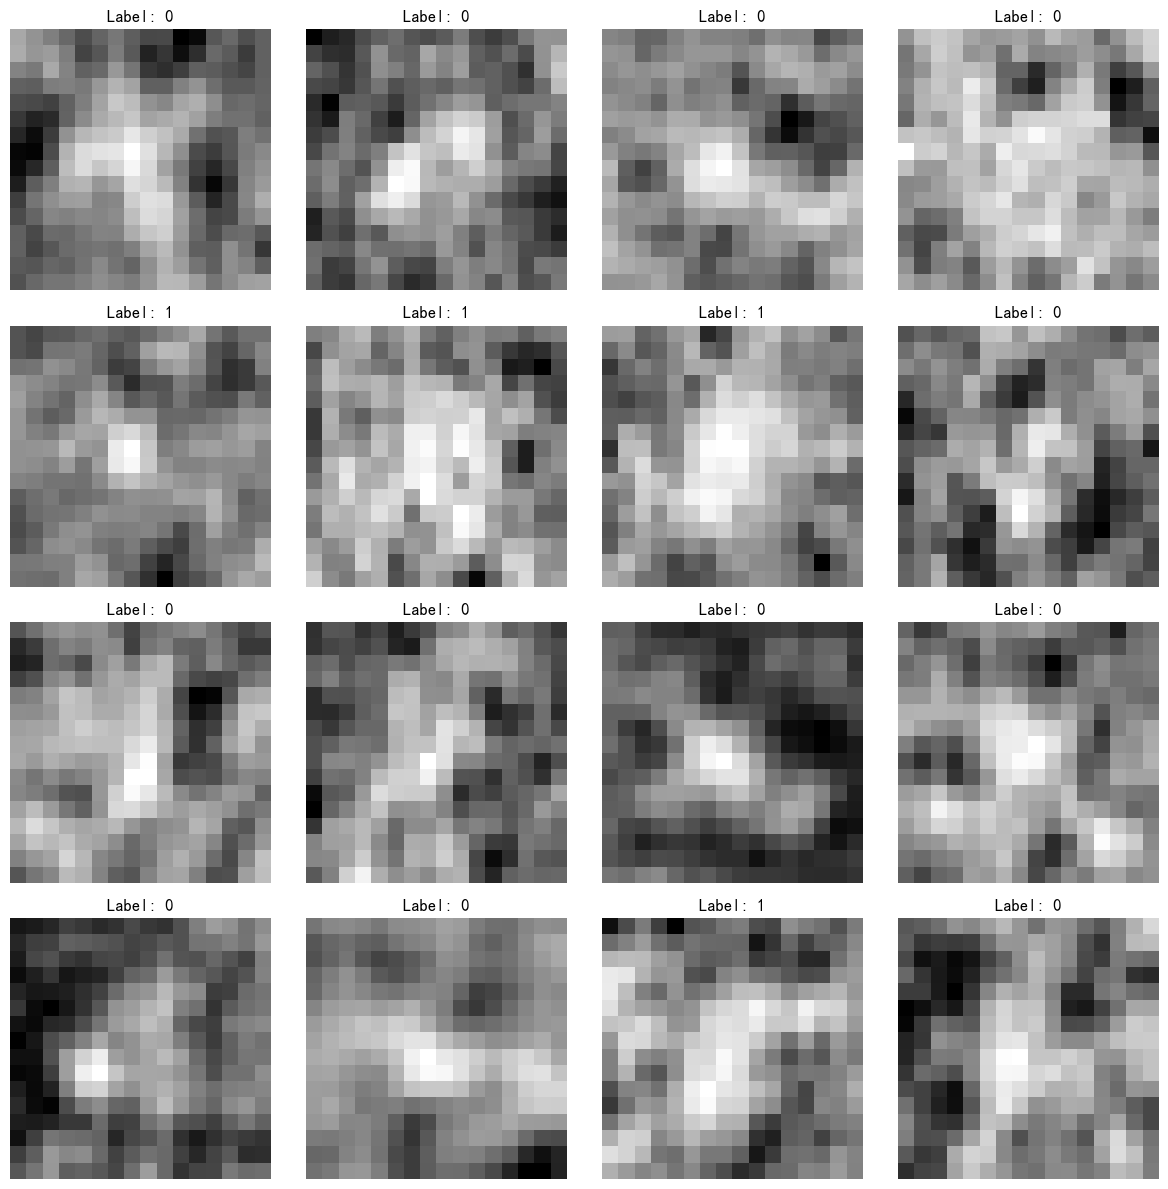

In [ ]:
def plot_raw_patches(raw_patches, labels, n=16):
    n = min(n, len(raw_patches))
    plt.figure(figsize=(12, 12))
    indices = np.random.choice(len(raw_patches), n, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i + 1)
        plt.imshow(raw_patches[idx], cmap='gray', origin='lower')
        plt.title(f"Label: {labels[idx]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_raw_patches(raw_patches, valid_labels, n=16)


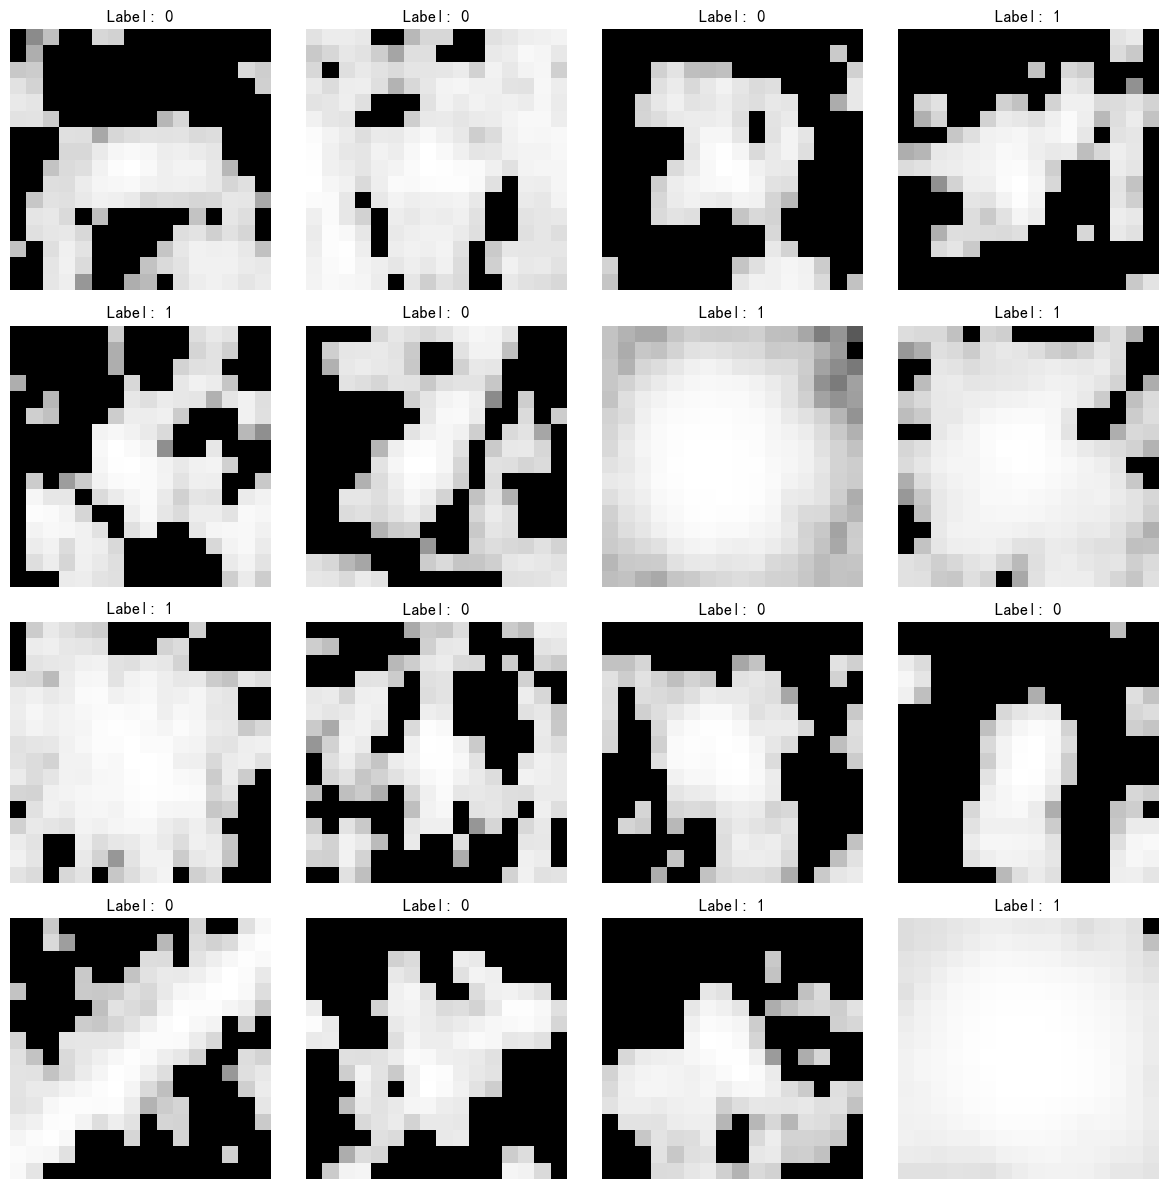

In [ ]:
def plot_patches(patches, labels, n=16):
    n = min(n, len(patches))
    plt.figure(figsize=(12, 12))
    indices = np.random.choice(len(patches), n, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i + 1)
        plt.imshow(patches[idx], cmap='gray', origin='lower')
        plt.title(f"Label: {labels[idx]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_patches(patches, valid_labels, n=16)


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

patches_tensor = torch.tensor(patches, dtype=torch.float32).unsqueeze(1)  
labels_tensor = torch.tensor(valid_labels, dtype=torch.float32).unsqueeze(1)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    patches_tensor, labels_tensor, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42
)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"训练样本数: {len(train_dataset)}, 验证样本数: {len(val_dataset)}, 测试样本数: {len(test_dataset)}")


训练样本数: 8700, 验证样本数: 2176, 测试样本数: 2719


In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # 16x16 -> 8x8

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # 8x8 -> 4x4

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()

        final_feature_size = 128 * (patch_size // 4) * (patch_size // 4)
        self.fc1 = nn.Linear(final_feature_size, 128)
        self.relu6 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.relu2(self.conv2(self.relu1(self.conv1(x))))
        x = self.pool1(x)
        x = self.relu4(self.conv4(self.relu3(self.conv3(x))))
        x = self.pool2(x)
        x = self.relu5(self.conv5(x))
        x = x.view(x.size(0), -1)
        x = self.relu6(self.fc1(x))
        x = self.fc2(x)  
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)


In [ ]:
model = CNNModel().to(device)
pos_weight_value = (labels_tensor == 0).sum() / (labels_tensor == 1).sum()
pos_weight = torch.tensor([pos_weight_value], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item() * val_inputs.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

model.eval()
test_loss = 0
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        loss = criterion(test_outputs, test_labels)
        test_loss += loss.item() * test_inputs.size(0)
test_loss /= len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}")

Epoch 1/20 — Train Loss: 0.9577, Val Loss: 0.9150
Epoch 2/20 — Train Loss: 0.9162, Val Loss: 0.9027
Epoch 3/20 — Train Loss: 0.9087, Val Loss: 0.8970
Epoch 4/20 — Train Loss: 0.9037, Val Loss: 0.8878
Epoch 5/20 — Train Loss: 0.8901, Val Loss: 0.9032
Epoch 6/20 — Train Loss: 0.8748, Val Loss: 0.9170
Epoch 7/20 — Train Loss: 0.8487, Val Loss: 0.9230
Epoch 8/20 — Train Loss: 0.8085, Val Loss: 0.9508
Epoch 9/20 — Train Loss: 0.7295, Val Loss: 1.1573
Epoch 10/20 — Train Loss: 0.6503, Val Loss: 1.1614
Epoch 11/20 — Train Loss: 0.5386, Val Loss: 1.4172
Epoch 12/20 — Train Loss: 0.4347, Val Loss: 1.6324
Epoch 13/20 — Train Loss: 0.3345, Val Loss: 2.4651
Epoch 14/20 — Train Loss: 0.2816, Val Loss: 2.4798
Epoch 15/20 — Train Loss: 0.2430, Val Loss: 2.3255
Epoch 16/20 — Train Loss: 0.1740, Val Loss: 2.8013
Epoch 17/20 — Train Loss: 0.1671, Val Loss: 2.7756
Epoch 18/20 — Train Loss: 0.1260, Val Loss: 2.7111
Epoch 19/20 — Train Loss: 0.1455, Val Loss: 3.2354
Epoch 20/20 — Train Loss: 0.1107, Val Lo

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
def evaluate_model(model, data_loader, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.sigmoid(outputs)  
            preds = (probs > threshold).float()

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    all_preds = all_preds.ravel()
    all_labels = all_labels.ravel()

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    return acc, precision, recall, f1


In [ ]:
print("🔍 Evaluating model on test set...")
evaluate_model(model, test_loader)


🔍 Evaluating model on test set...
Accuracy : 0.6966
Precision: 0.4323
Recall   : 0.4557
F1 Score : 0.4437


(0.6965796248620817,
 0.4323258869908016,
 0.4556786703601108,
 0.44369521240728255)

: 